# Function to test in the early phrese

From a sequence, chose casually n positions and from these poritions takes m foward bases, creating  in this way a read
starting at position n, with lenght m. The number of reads are: $ (len(seq) / lenght_reads) \times coverage  $. Can creates holes.

In [50]:
from Bio import pairwise2
from Bio import SeqIO
import yaml
from math import modf
from Bio.Seq import Seq
from inspyred import swarm
from inspyred import benchmarks
from inspyred import ec
from inspyred.ec import selectors
from collections import deque
from collections import Counter
import numpy as np
import itertools
import random
import seaborn as sns
import matplotlib.pyplot as plt


In [60]:
def comstum_reads(seq: str, length_reads = 10, coverage = 5, verbose = False) -> list:
    
    """The function split the sequence in input in reads.
    The splitting is done using random numbers, the amount of reds is given by: (len(seq)/length_read)*coverage.
    """

    number_of_reads = int(len(seq)/length_reads) * coverage
    starting_pos = random.sample(range(0, len(seq)-length_reads+1), number_of_reads)
    reads = []

    for num in starting_pos:
        reads.append(seq[num:num+length_reads])

    if verbose == True:
        y = [0 for i in range(0,len(seq)+1)]
        for i in starting_pos:
            for j in range(i, i+length_reads+1):
                y[j] += 1 
        sns.set_theme(style="darkgrid")
        sns.lineplot(y)
        print(f"There are {y.count(0)} bases that are not have been transcriped.")

    return reads

In [53]:
def eval_allign(reads:list, par = [2, -5, -22, -5]):
    
    """Function that evaulates the alignment

    reads: list of DNA sequences, each read is a string

    par: list of parameters to perform the alignment
    es (the examples represent the default parameters):
    match_score = 2,
    mismatch_penalty = -5,
    gap_open_penalty = -22,
    gap_extension_penalty = -5

    output:
    Matrix with the weigts (distances) between the reads (nodes)
    This matrix can host two kind of entires: alignment scores (integers) and lists. Each list reports: the index of the 
    beginning of the alignment with respect to the first read of the couple (read i), the index of the end of the alignment
    with respect to read i, the index of the beginning of the alignment with respect to the second read of the couple (j)
    and the index of the end of the alignment with respect to read j. All indexes are stored as included. 
    
    An entry ij is filled with the alignment score OR with the alignment list, with the other entry being saved in position
    ji. The decision is made on the basis of which of the two reads starts first in the pairwise alignment. 
    
    """
    
    length = len(reads)
    # initialization of the matrix
    weigth_matrix = [[0] * len(reads) for x in range(len(reads))]

    # The score of the allingment of read[1] to read[2] is the same of the opposite (read[2] to read[1])
    # So when the function found the diretionality of the allignment put the score in rigth spot and a 0 in the wrong one.
    visited = deque([j for j in range(length)])
    
    for i in range(length):

        for j in visited:

            if i == j:
                # the diagonal of the matrix has 0 score because we are allinging the same sequence
                continue
            else:
                # pairwise must return a positive score, if there is no one it return None
                allignment = pairwise2.align.localms(Seq(reads[i]), Seq(reads[j]), par[0], par[1], par[2], par[3])
                if len(allignment) == 0:
                    #   allignment = 1    to decide if put 1 or 0
                    continue
                else:
                    allignment = allignment[0]
                      
                start_r1 = allignment[3]                                              # Start of the alignment, with respect to the first read (i)
                end_r1 = allignment[4]                                                # End of the alignment,  with respect to the first read (i)
                start_r2 = allignment[3] - allignment[1].count('-')                   # Start of the alignment, with respect to the second read (j)
                end_r2 = start_r2 + (end_r1 - start_r1)                               # End of the alignment, with repsect to the second read (j)
                # return object [seqA, seqB, score, start(inc), end(ex)]

                if allignment[0][0] == "-":
                    # This means that the first reads in input has a gap at the beginning of the allignment.
                    # Therefore the first reads in input (i) is downstream,
                    # so I add the score in the matrix but in the position (j,i) instead of (i,j), where the alignment list is stored
                    weigth_matrix[j][i] = float(allignment[2])
                    weigth_matrix[i][j] = [start_r1, end_r1-1, start_r2, end_r2-1]    # Start and end included

                else:
                    # In the opposite case, where the i read is upstream, (i,j) has the score, while (j,i) hosts the alignment list                    
                    weigth_matrix[i][j] = float(allignment[2])
                    weigth_matrix[j][i] = [start_r1, end_r1-1, start_r2, end_r2-1]    # Start and end included

                    
        visited.popleft()

    return weigth_matrix 

### EVAL_ALLIGN TEST ###

reads_test = ['CTCAGGATAGAC', 'TTGATCGACCTA', 'ATCGTCCTAAAA', 'AGAACAAAATGT']

w_test = eval_allign(reads_test)

for s in w_test:
    print(*s)

0 7.0 4.0 6.0
[5, 11, 2, 8] 0 11.0 4.0
[7, 8, 7, 8] [3, 11, 0, 8] 0 8.0
[8, 10, 0, 2] [7, 8, 3, 4] [8, 11, 5, 8] 0


In [54]:
def consensus_reconstructor(path:list, reads:list, positions:list) -> str:
    
    # CONSENSUS MATRIX BUILDER: builds a matrix containing all the pairwise local alignments between the reads in the path; all the empty positions are filled with '-'.
    
    consensus_matrix = []
    consensus_matrix.append([i for i in reads[path[0].element[0]]])
    shift_required = 0                                                          # Initial shift is 0 (no shift, the first read starts where the consensus matrix starts)
    
    new_path = []
    for i in path:
        new_path.append(i.element)

    for i,j in new_path:
        consensus_matrix.append([i for i in reads[j]])
        
    iteration_number = -1
    # print(consensus_matrix)
    for i,j in new_path:
        iteration_number = iteration_number + 1
        nums = positions[j][i]
        start_r1 = nums[0]                                                      # Index of the begininng of the alignment, with respect to the read i, included
        # end_r1 = nums[1]                                                        # Index of the end of the alignment, with respect to the read i, included
        start_r2 = nums[2]                                                      # Index of the begininng of the alignment, with respect to the read j, included
        # end_r2 = nums[3]                                                        # Index of the end of the alignment, with respect to the read j, included
        shift_required = shift_required + (start_r1 - start_r2)                 # Amount of shifting required to translate the read j up to the correct position
        for i in range(shift_required):
            consensus_matrix[iteration_number+1].insert(0,"-")
        # consensus_matrix[iteration_number+1].insert(0, '-'*shift_required)      # Performing the shift
    # print(consensus_matrix)
    max_length = len(consensus_matrix[iteration_number+1])                      # Filling the empty positions with '-'
    for row in consensus_matrix:
        row.extend('-'*(max_length - len(row)))
    
    # CONSENSUS SEQUENCE BUILDER: goes through all columns in the consensus matrix and selects, for each column, the most frequent base. Then it elongates a string with the 
    # selected base. If two or more bases have the same frequency, the first one met is chosen.
    
    consensus_seq = ''
    for k in range(len(consensus_matrix[0])):                                        # All rows in the consensus matrix have the same length, so I choose the first one
        bases_in_current_column = []
        for row in consensus_matrix:                                                 # Appending all elements in the current consensus matrix column in the list 'bases_in_current_column' 
            if row[k] != '-':                                                        # If the element is a spacer, we do not add it
                bases_in_current_column.append(row[k])
        most_present_base = Counter(bases_in_current_column).most_common(1)[0][0]    # Most common base in 'bases_in_current_column' is found with the imported Counter class
        consensus_seq = consensus_seq + most_present_base                            # If two or more bases have the same frequency, Counter chooses by default the first base met.  
    
    return consensus_matrix, consensus_seq


There are 44 bases that are not have been transcriped.


KeyboardInterrupt: 

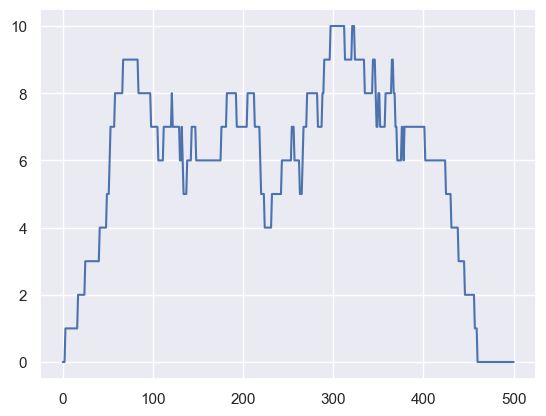

In [5]:
from Final_ANT_algorithm import run_simulation
def tuning_parameters(yaml_file = "training.yaml"):
    """
    """

    with open(yaml_file, "r") as file:
        file = yaml.safe_load(file)

    sequences = file["sequence_to_test"].values()

    for population_size in file["pop_size"]:
        for max_generation in file["max_generations"]:
            for learning_rate in file["learning_rate"]:
                for evaporatin_rate in file["evaporatin_rate"]:
                    for seq_record in SeqIO.parse(name_sequence, format="fasta"):
                        seq += seq_record.seq.upper()
                        run_simulation()
                    


    with open(yaml_file, "a") as y_file:

        for name_sequence in sequences:
            seq = ""
            y_file["scores"] = ""
            for param in parameters:
                print(name_sequence[7:-4])
                print(param)
                for seq_record in SeqIO.parse(name_sequence, format="fasta"):
                    seq += seq_record.seq.upper()
                print(seq[:80])
                # y_file["scores"].
                # run algorithm
                # file["scores"]
                # file["scores"][f"{name_sequence[7:]}"][f"{parameters}"] = pairwise2.align.globalmx(our_sequence, sequence, 1, -1)[2]

tuning_parameters()

In [55]:
class Assembly_problem():
    """Defines the de novo genome assembly problem.
    
    This class based on the Traveling Salesman problem defines the problem
    of assembling a new genome for which no reference is available (de novo assembly):
    given a set of genomic reads and their pairwise overlap score, find the
    path generating the longest consensus sequence. This problem assumes that 
    the ``weights`` parameter is an *n*-by-*n* matrix of pairwise 
    overlap among *n* reads. This problem is treated as a 
    maximization problem, so fitness values are determined to be the 
    proportional to the sum of the overlaps between each couple of reads
    (the weight of the edge) and the length of the final assembled sequence.
    
    Public Attributes:
    
    - *weights* -- the two-dimensional list of pairwise overlap 
    - *components* -- the set of ``TrailComponent`` objects constructed
      from the ``weights`` attribute, where the element is the ((source,
      destination), weight)
    - *bias* -- the bias in selecting the component of maximum desirability
      when constructing a candidate solution for ant colony optimization 
      (default 0.5)
    
    """
    def __init__(self, reads, experimental_length):
        self.sigma = 0.1
        self.experimental_length = experimental_length
        self.reads = reads
        self.weights = eval_allign(self.reads)
        self.components = [swarm.TrailComponent((i, j), value=(self.weights[i][j])) for i, j in itertools.permutations(range(len(self.weights)), 2) if (type(self.weights[i][j]) == float) and (self.weights[i][j] != 0)]
        self.bias = 0.65
        self.bounder = ec.DiscreteBounder([i for i in range(len(self.weights))])
        self.best_sequence = None
        self.maximize = True
        self._use_ants = False

    # def generator(self, random, args):
    #         """Return a candidate solution for an evolutionary computation."""
    #         locations = [i for i in range(len(self.weights))]
    #         random.shuffle(locations)
    #         return locations
    
    def constructor(self, random, args):
        """Return a candidate solution for an ant colony optimization."""

        candidate = []
        feasible_components = [1]   #Fake initialization to allow while loop to start
        
        # We need to visit all the nodes that CAN be visited, the graph is directed and not complete, meaning we can have no more nodes to visit without visiting all the
        # nodes in the graph, thus, our termination condition is not visitin all the nodes but not having anymore feasible components
        while len(feasible_components) > 0:
            # At the start of the visit, all the components are feasible
            if len(candidate) == 0:
                feasible_components = self.components
            elif len(candidate) == len(self.weights) - 1: # All the nodes have been visited
                return candidate
            else:
                # Update feasible components and set of already visited nodes considering the node visited in the last iteration
                last = candidate[-1]
                already_visited = [c.element[0] for c in candidate]
                already_visited.extend([c.element[1] for c in candidate])
                already_visited = set(already_visited)
                feasible_components = [c for c in self.components if c.element[0] == last.element[1] and c.element[1] not in already_visited]
            # Choose a feasible component
            if len(feasible_components) == 0:
                return candidate
            if random.random() <= self.bias:
                next_component = max(feasible_components)
            else:
                next_component = selectors.fitness_proportionate_selection(random, feasible_components, {'num_selected': 1})[0]
            candidate.append(next_component)
        return candidate
    
    def evaluator(self, candidates, args):
            """Return the fitness values for the given candidates."""
            #P rappresenta la lunghezza stimata del nostro dna
            #Pm rappresenta P-0.04P
            #PM rappresenta P+0.04P
            #sigma = peso della penalità, che aumenta all'aumentare della distanza dal valore di lunghezza dal limite superiore o inferiore.
            fitness = []
            P = self.experimental_length
            Pm=P-0.04*P
            PM=P+0.04*P
            for candidate in candidates:
                    total = 0
                    lencandidate=len(consensus_reconstructor(path = candidate, reads=self.reads, positions=self.weights)[1])
                    for c in candidate:
                        total += self.weights[c.element[0]][c.element[1]]
                    if lencandidate>=Pm:
                        if lencandidate<=PM :
                                fitness.append(total) 
                        else:
                                total=total-self.sigma*(lencandidate-PM)
                                fitness.append(total)
                    else:
                            total=total-self.sigma*(Pm-lencandidate)
                            fitness.append(total)
            return fitness

In [56]:
def plot_observer(population, num_generations, num_evaluations, args):
    """Plot the output of the evolutionary computation as a graph.
        
        This function plots the performance of the EC as a line graph
        using matplotlib and numpy. The graph consists of a blue line
        representing the best fitness, a green line representing the
        average fitness, and a red line representing the median fitness.
        It modifies the keyword arguments variable 'args' by including an
        entry called 'plot_data'.
        
        If this observer is used, the calling script should also import
        the matplotlib library and should end the script with::
        
        matplotlib.pyplot.show()
        
        Otherwise, the program may generate a runtime error.
        
        .. note::
        
        This function makes use of the matplotlib and numpy libraries.
        
        .. Arguments:
        population -- the population of Individuals
        num_generations -- the number of elapsed generations
        num_evaluations -- the number of candidate solution evaluations
        args -- a dictionary of keyword arguments
        
        """
    import matplotlib.pyplot as plt
    import numpy
    
    stats = inspyred.ec.analysis.fitness_statistics(population)
    best_fitness = stats['best']
    worst_fitness = stats['worst']
    median_fitness = stats['median']
    average_fitness = stats['mean']
    colors = ['black', 'blue', 'green', 'red']
    labels = ['average', 'median', 'best', 'worst']
    data = []
    if num_generations == 0:
        figure(args["fig_title"] + ' (fitness trend)')
        plt.ion()
        data = [[num_evaluations], [average_fitness], [median_fitness], [best_fitness], [worst_fitness]]
        lines = []
        for i in range(4):
            line, = plt.plot(data[0], data[i+1], color=colors[i], label=labels[i])
            lines.append(line)
        args['plot_data'] = data
        args['plot_lines'] = lines
        plt.xlabel('Evaluations')
        plt.ylabel('Fitness')
    else:
        data = args['plot_data']
        data[0].append(num_evaluations)
        data[1].append(average_fitness)
        data[2].append(median_fitness)
        data[3].append(best_fitness)
        data[4].append(worst_fitness)
        lines = args['plot_lines']
        for i, line in enumerate(lines):
            line.set_xdata(numpy.array(data[0]))
            line.set_ydata(numpy.array(data[i+1]))
        args['plot_data'] = data
        args['plot_lines'] = lines
    ymin = min([min(d) for d in data[1:]])
    ymax = max([max(d) for d in data[1:]])
    yrange = ymax - ymin
    plt.xlim((0, num_evaluations))
    plt.ylim((ymin - 0.1*yrange, ymax + 0.1*yrange))
    plt.draw()
    plt.legend()

    plt.savefig(args['save_path'])
    

There are 35 bases that are not have been transcriped.


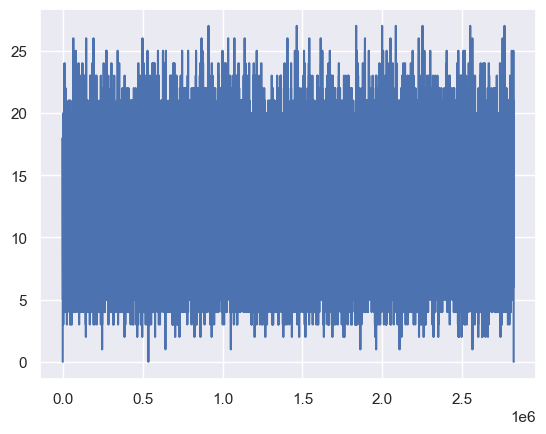

In [98]:
ref="ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTCAGGAAACATTTTCAGACCTATGGAAACTACTTCCTGAAAACAACGTTCTGTCCCCCTTGCCGTCCCAAGCAATGGATGATTTGATGCTGTCCCCGGACGATATTGAACAATGGTTCACTGAAGACCCAGGTCCAGATGAAGCTCCCAGAATGCCAGAGGCTGCTCCCCCCGTGGCCCCTGCACCAGCAGCTCCTACACCGGCGGCCCCTGCACCAGCCCCCTCCTGGCCCCTGTCATCTTCTGTCCCTTCCCAGAAAACCTACCAGGGCAGCTACGGTTTCCGTCTGGGCTTCTTGCATTCTGGGACAGCCAAGTCTGTGACTTGCACGTACTCCCCTGCCCTCAACAAGATGTTTTGCCAACTGGCCAAGACCTGCCCTGTGCAGCTGTGGGTTGATTCCACACCCCCGCCCGGCACCCGCGTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGGCGCTGCCCCCACCATGAGCGCTGCTCAGATAGCGATGGTCTGGCCCCTCCTCAGCATCTTATCCGAGTGGAAGGAAATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATAGTGTGGTGGTGCCCTATGAGCCGCCTGAGGTTGGCTCTGACTGTACCACCATCCACTACAACTACATGTGTAACAGTTCCTGCATGGGCGGCATGAACCGGAGGCCCATCCTCACCATCATCACACTGGAAGACTCCAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACAGAGGAAGAGAATCTCCGCAAGAAAGGGGAGCCTCACCACGAGCTGCCCCCAGGGAGCACTAAGCGAGCACTGCCCAACAACACCAGCTCCTCTCCCCAGCCAAAGAAGAAACCACTGGATGGAGAATATTTCACCCTTCAGATCCGTGGGCGTGAGCGCTTCGAGATGTTCCGAGAGCTGAATGAGGCCTTGGAACTCAAGGATGCCCAGGCTGGGAAGGAGCCAGGGGGGAGCAGGGCTCACTCCAGCCACCTGAAGTCCAAAAAGGGTCAGTCTACCTCCCGCCATAAAAAACTCATGTTCAAGACAGAAGGGCCTGACTCAGACTGA"
seq = ""
for seq_record in SeqIO.parse("C:\\Users\\filoa\\OneDrive\\Desktop\\Bio AI\\Project_Bio_AI\\Data\\Aspergillus_flavus.fna", format="fasta"):
    seq += seq_record.seq.upper()
expected_length = len(seq)
reads = comstum_reads(seq[:expected_length], length_reads = 160, verbose=True, coverage=12)

In [99]:
import inspyred
import os
from random import Random
#from utils.utils_07.exercise_1 import *
#from utils.utils_07.plot_utils import *

import collections
collections.Iterable = collections.abc.Iterable
collections.Sequence = collections.abc.Sequence

# common parameters
pop_size = 100
max_generations = 50
seed = 10
prng = Random(seed)
display = True
# ACS specific parameters
evaporation_rate = 0.4
learning_rate = 0.1

args = {}
args['fig_title'] = "ACS"
args['save_path'] = "C:\\Users\\filoa\\OneDrive\\Desktop\\Bio AI\\Project_Bio_AI\\results\\Aspergillus\\image.png"

if not os.path.exists(args['save_path']):
    os.makedirs

# run ACS
problem = Assembly_problem(reads = reads, experimental_length = expected_length)
ac = inspyred.swarm.ACS(prng, problem.components)
ac.observer = [plot_observer]
ac.terminator = inspyred.ec.terminators.generation_termination


final_pop = ac.evolve(generator=problem.constructor, 
                      evaluator=problem.evaluator, 
                      bounder=problem.bounder,
                      maximize=problem.maximize, 
                      pop_size=pop_size,
                      max_generations=max_generations,
                      evaporation_rate=evaporation_rate,
                      learning_rate=learning_rate,
                      **args)
best_ACS = max(ac.archive)

d = consensus_reconstructor(path = best_ACS.candidate, reads=reads, positions=eval_allign(reads))[1]
a = pairwise2.align.localms(d, ref[:expected_length], 3,-1,-3,-2)[0]
new_file = open("C:\\Users\\filoa\\OneDrive\\Desktop\\Bio AI\\Project_Bio_AI\\results\\Aspergillus\\additiona_info.txt", "w")
results_to_write = ["The real sequence\n", a[0], "\n", "Our reconstructed sequence:\n", a[1], "\n",
                    "Score of the allignment after the reconstruction:\n", str(a[2]), "\n", "Length of the reads: 160"]
new_file.writelines(results_to_write)
new_file.close()

MemoryError: 

In [73]:
print(best_ACS.candidate)
d = consensus_reconstructor(path = best_ACS.candidate, reads=reads, positions=eval_allign(reads))[1]
print(len(d))
# print(d)
# print(ref[1:200])
a = pairwise2.align.localms(d, ref[:expected_length], 3,-1,-3,-2)[0]
print(a[0])
print(a[1])
print(a[2])
i = 1
new_file = open("C:\\Users\\filoa\\OneDrive\\Desktop\\Bio AI\\Project_Bio_AI\\results\\1\\additiona_info.txt", "w")
results_to_write = ["The real sequence\n", str(ref[:expected_length]), "\n", "Our reconstructed sequence:\n", str(d), "\n",
                    "Score of the allignment after the reconstruction:\n", str(a[2])]
new_file.writelines(results_to_write)
new_file.close()

[((5, 0), 54.0), ((0, 27), 54.0), ((27, 15), 58.0), ((15, 25), 30.0), ((25, 3), 40.0), ((3, 12), 40.0), ((12, 30), 54.0), ((30, 9), 58.0), ((9, 34), 56.0), ((34, 19), 56.0), ((19, 13), 48.0), ((13, 20), 58.0), ((20, 17), 30.0), ((17, 23), 50.0), ((23, 2), 48.0), ((2, 35), 12.0), ((35, 32), 50.0), ((32, 18), 8.0), ((18, 33), 44.0), ((33, 10), 52.0), ((10, 22), 10.0), ((22, 16), 50.0), ((16, 29), 58.0), ((29, 21), 48.0), ((21, 26), 12.0), ((26, 11), 58.0), ((11, 8), 42.0), ((8, 4), 56.0), ((4, 31), 56.0), ((31, 28), 26.0), ((28, 6), 12.0), ((6, 7), 50.0), ((7, 14), 50.0), ((14, 24), 58.0), ((24, 1), 8.0)]
227
--GGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTCAGGAAACATTTTCAGACCTATGGAAACTACTTCCTGAAAACAACGTTCTGTCCCCCTTTCAGTCAAGACCCAGGTCCAGATGATTTGATGCTGTCCCCGGACGATATTGAACAATGGATGATTTGATGCTGTCCCCGGACGATATCAAGCAATGGATGATTTGATGCTGTCCCCGGAGAGTCA
ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTCAGGAAACATTTTCAGACCTATGGAAACTACTTCCTGAAAACAACGTTCTGTCCCCCTTGCCGTC----CCAAGCAATGGATGATTTGATGCTGTCCCCGGACGATATTG